# Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score, roc_curve,auc
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Importing Dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# Encoding Categorical Values

In [4]:
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [5]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)

In [6]:
rus = RandomUnderSampler(random_state=42,replacement=True)
X_, y = rus.fit_resample(X,y)
X = pd.DataFrame(X_,columns=X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Spliting into Train and Test Sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

# Hyperparameter tuning using GridSearchCV

In [8]:
def tune_hyperparameters(model,X,y):
  param_grid = {
      'n_estimators' : [10,50,250,1000],
      'learning_rate' : [0.001,0.01,0.1,1.0,10]
  }
  grid_search = GridSearchCV(model,param_grid=param_grid)
  grid_search.fit(X,y)
  print("Best Params: ",grid_search.best_params_)
  return grid_search.best_params_

In [9]:
decision_tree_parameters = {'criterion': 'entropy', 'max_depth': 6, 'max_features': 0.33334, 'max_leaf_nodes': 50, 'min_samples_leaf': 15, 'min_samples_split': 2, 'random_state': 0}

In [10]:
best_parameters_raw = tune_hyperparameters(AdaBoostClassifier(random_state=0,base_estimator=DecisionTreeClassifier(**decision_tree_parameters)),X_train,y_train)

Best Params:  {'learning_rate': 0.01, 'n_estimators': 1000}


# AdaBoostClassifier

In [11]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("F1 Score: ",f1_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

  
  fpr,tpr,thresholds = roc_curve(y_test,y_pred)
  plt.plot(fpr, tpr,color='green',label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
  plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

Accuracy:  0.7272727272727273
Precision:  0.75
Recall:  0.72
F1 Score:  0.7346938775510204
Confusion Matrix:
 [[50 18]
 [21 54]]


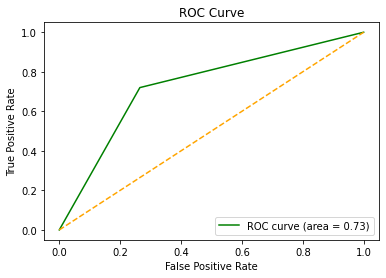

In [12]:
train_predict_evaluate(AdaBoostClassifier(random_state=0,base_estimator=DecisionTreeClassifier(**decision_tree_parameters),**best_parameters_raw),X_train,y_train,X_test)

# K-Fold Cross Validation

In [13]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  metrics = []
  metrics.append(np.mean(scores['test_accuracy']))
  metrics.append(np.mean(scores['test_precision']))
  metrics.append(np.mean(scores['test_recall']))
  metrics.append(np.mean(scores['test_f1']))

  print("Accuracy: ",metrics[0])
  print("Precision: ",metrics[1])
  print("Recall: ",metrics[2])
  print("F1 Score: ",metrics[3])

In [14]:
cross_validation(AdaBoostClassifier(random_state=0,base_estimator=DecisionTreeClassifier(**decision_tree_parameters),**best_parameters_raw),X,y)

Accuracy:  0.7363493840985441
Precision:  0.7395066885356807
Recall:  0.734840425531915
F1 Score:  0.7351298426374147
